<table width=100%>
    <tr>
        <td width = 40% align = "left">
            <h3> MTH786 Machine Learning with Python</h3>
        </td>
        <td width = 35%>            
        </td>
        <td width = 25% align = "left">
            <h3>Semester A </h3>
        </td>
    </tr>
    <tr>
        <td width = 40% align = "left">
            <h3> Coursework 8</h3>
        </td>
        <td width = 35%>            
        </td>
        <td width = 25% align = "left">
            <h3>Dr Nicola Perra </h3>
        </td>
    </tr>
</table>

In [1]:
import numpy as np
from numpy.testing import assert_array_almost_equal, assert_array_equal
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

/home/sami/miniforge3/envs/ML/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### Nearest neighbour classification
In this exercise you will work with a data set you are familiar with: $\mathtt{heigh\_weight.csv}$. By completing this exercise you will learn how to solve binary classification problem with non-parametric method. In the second part we will learn how to solve the classification problem for titanic data using logistic regression method.

We start by loading data. **Important:** please check that file $\mathtt{height\_weight.csv}$ is located in the same folder with your Jupyter notebook.

In [2]:
types = np.genfromtxt("height_weight.csv", delimiter=",", skip_header=1, usecols=[0], \
                        converters={0: lambda x: 0 if "A" in x else 1})
heights = np.genfromtxt("height_weight.csv",
                        delimiter=",",
                        skip_header=1,
                        usecols=[1])
weights = np.genfromtxt("height_weight.csv",
                        delimiter=",",
                        skip_header=1,
                        usecols=[2])
indexes = np.argsort(heights)

height_weight_input = np.c_[heights[indexes], weights[indexes]]
height_weight_output = types[indexes]


def standardise(data_matrix):
    row_of_means = np.mean(data_matrix, axis=0)
    standardised_matrix = data_matrix - row_of_means
    row_of_stds = np.std(standardised_matrix, axis=0)
    return (standardised_matrix / row_of_stds), row_of_means, row_of_stds


def de_standardise(standardised_matrix, row_of_means, row_of_stds):
    matrix = np.copy(standardised_matrix * row_of_stds)
    return matrix + row_of_means


height_weight_input, height_weight_row_of_means, height_weight_row_of_stds = standardise(
    height_weight_input)


def plot_height_weight(data_input, data_output):
    height_weight_de_standardised = de_standardise(data_input,
                                                   height_weight_row_of_means,
                                                   height_weight_row_of_stds)
    
    """
    - Interesting way to plot classes seperately.
    - Plotting Height vs Weights, whilst considering which class each pair is from.
    - First scatter for ex: select as x, all rows of the first column such that the data_output row for x has 0.
    """
    plt.scatter(height_weight_de_standardised[:,0][data_output == 0], \
                height_weight_de_standardised[:,1][data_output == 0], s=1, c = 'r')
    plt.scatter(height_weight_de_standardised[:,0][data_output == 1], \
                height_weight_de_standardised[:,1][data_output == 1], s=1, c = 'b')
    plt.xlabel('Height', fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel('Weight', fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout

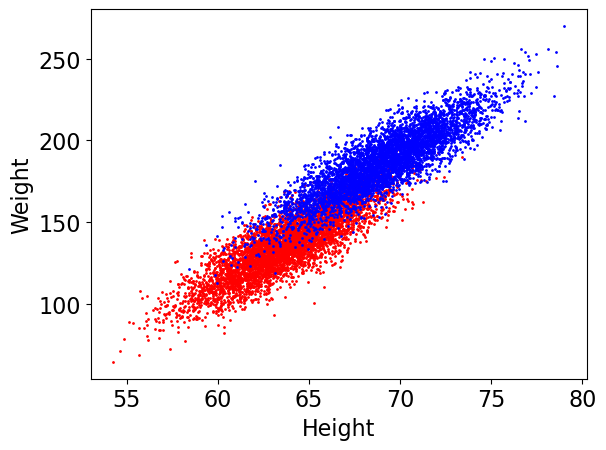

In [3]:
plot_height_weight(height_weight_input, height_weight_output)

Our main goal is to identify the type by studying their height and weight. We will end up with building a classifier which will split the height–weight plane into two regions: one corresponding to type A and another to type B. To achieve this we suggest using the $K$-nearest neighbour classification method.

1. Write the function $\mathtt{pairwise\_distances}$ that takes two arguments $\mathtt{from\_data}$ and $\mathtt{to\_data}$—both NumPy arrays of the same width and possibly different height.

For

$$
\mathtt{from\_data} =
\begin{pmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots    & \vdots    & \ddots & \vdots \\
x^{(p)}_1 & x^{(p)}_2 & \ldots & x^{(p)}_d 
\end{pmatrix},
\quad
\mathtt{to\_data} =
\begin{pmatrix}
y^{(1)}_1 & y^{(1)}_2 & \ldots & y^{(1)}_d \\
y^{(2)}_1 & y^{(2)}_2 & \ldots & y^{(2)}_d \\
\vdots    & \vdots    & \ddots & \vdots \\
y^{(q)}_1 & y^{(q)}_2 & \ldots & y^{(q)}_d 
\end{pmatrix}
$$

the output should be

$$
\mathtt{pairwise\_distances} =
\begin{pmatrix}
\mathrm{dist}(x^{(1)},y^{(1)}) &
\mathrm{dist}(x^{(1)},y^{(2)}) & \ldots & \mathrm{dist}(x^{(1)},y^{(q)}) \\
\mathrm{dist}(x^{(2)},y^{(1)}) &
\mathrm{dist}(x^{(2)},y^{(2)}) & \ldots & \mathrm{dist}(x^{(2)},y^{(q)}) \\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{dist}(x^{(p)},y^{(1)}) &
\mathrm{dist}(x^{(p)},y^{(2)}) & \ldots & \mathrm{dist}(x^{(p)},y^{(q)})
\end{pmatrix}.
$$


In [4]:
def pairwise_distances(from_data, to_data):
    """
    Naive approach (that works!):
        distances = np.ndarray((len(from_data), len(to_data)))
        for i in range(len(from_data)):
            for j in range(len(to_data)):
                d_ij = np.linalg.norm(from_data[i,:] - to_data[j, :])
                distances[i, j] = d_ij
        return distances
    
    """
    # Much better approach using broadcasting
    # 
    diffs = from_data[:, np.newaxis, :] - to_data[np.newaxis, :, :]
    return np.linalg.norm(diffs, axis=2)

            


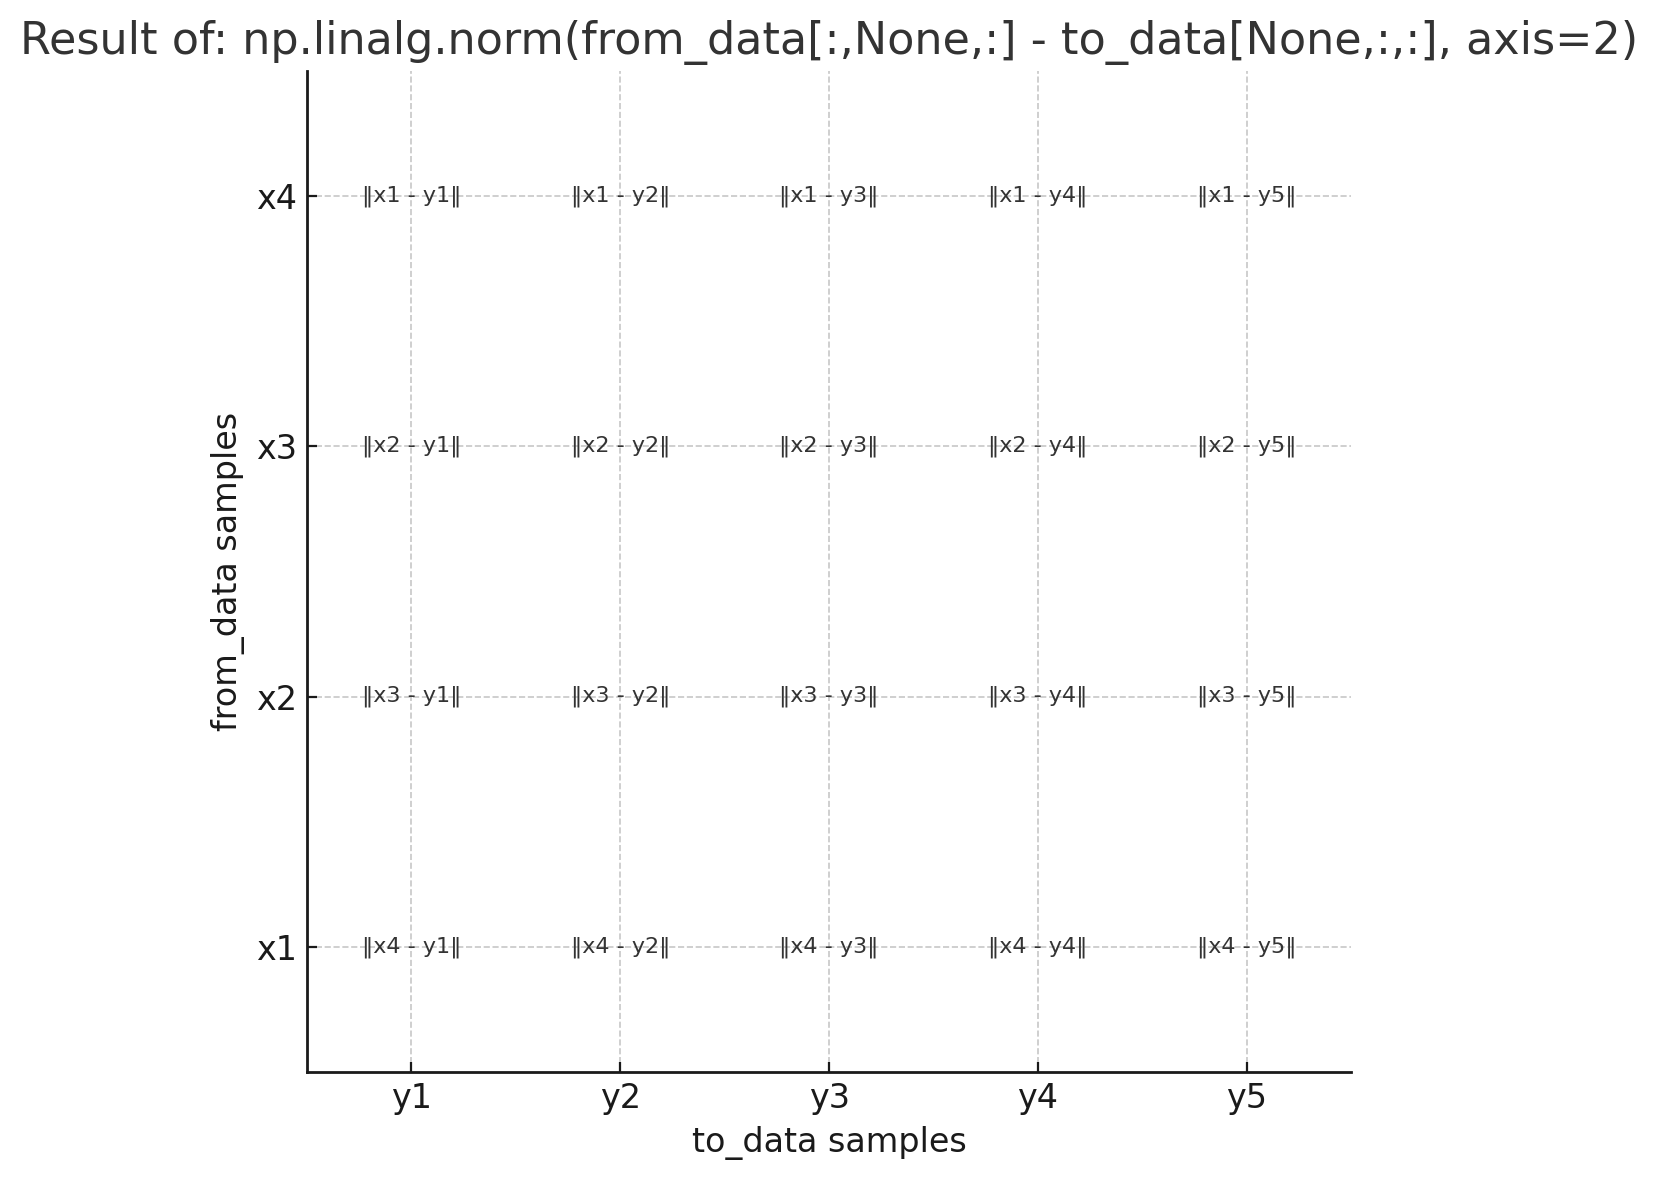

Test your function with the following unit tests

In [5]:
test_from_data = np.array([[0, 1, 2], [3, 4, 5]])
test_to_data = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]])
assert_array_almost_equal(pairwise_distances(test_from_data, test_to_data), np.array([[ 0., 5.19615242, 10.39230485, 15.58845727],\
                                                                                      [ 5.19615242,  0., 5.19615242, 10.39230485]]))

2. Write a function $\mathtt{nearest\_neighbour\_classification}$ that performs nearest neighbour classiffication as introduced in the lecture notes and that takes four arguments 
- $\mathtt{testing\_inputs}$ - a NumPy array of input samples to be classiffied
- $\mathtt{training\_inputs}$ - a NumPy array of data points for which the classification is known
- $\mathtt{training\_outputs}$ - a NumPy array of class labels for $\mathtt{training\_inputs}$ data
- $\mathtt{no\_of\_neighbours}$ - an integer argument that specifies how many neighbours we take into account to determine the class labels for the $\mathtt{testing\_inputs}$. Use the Euclidean norm to measure the distance between samples.

To implement the classification algorithm you may follow the below steps:  

a. Calculate the pairwise distances between testing and training data

b. Sort the pairwise distances by rows (sort rather indices)

c. For every row (data input) evaluate labels of the closest $K$ points 

d. Assign a data input with the class label that appears the most in between $K$ closest points

In [6]:
X = np.random.randint(10, size=(3,5))
X
print(X)

np.argsort(X)

[[8 3 0 8 3]
 [3 6 6 1 8]
 [9 0 6 8 7]]


array([[2, 1, 4, 0, 3],
       [3, 0, 1, 2, 4],
       [1, 2, 4, 3, 0]])

In [7]:
def nearest_neighbour_classification(testing_inputs, training_inputs,
                                     training_outputs, no_of_neighbours):
    distances = pairwise_distances(testing_inputs, training_inputs)
    sorted_indicies = np.argsort(distances)
    labels = np.ndarray(shape=(distances.shape[0], no_of_neighbours), dtype=int)
    for i in range(distances.shape[0]):
        for j in range(no_of_neighbours):
            labels[i, j] = training_outputs[sorted_indicies[i,j]]
    
    most_f = np.array([np.bincount(row).argmax() for row in labels])
    return most_f



Test your function with the following unit tests

In [8]:
test_data_inputs = np.array([[15], [6], [18]])
test_training_inputs = np.array([[10], [8], [17], [5], [12], [10], [20], [1],
                                 [11]])
test_training_outputs = np.array([1, 1, 1, 0, 0, 1, 1, 0, 1])
test_no_of_neighbours = 1
assert_array_almost_equal(nearest_neighbour_classification(test_data_inputs, test_training_inputs, \
                                                           test_training_outputs, test_no_of_neighbours),\
                          np.array([1, 0, 1]))

In [9]:
test_data_inputs = np.array([[16, 0], [13, 6], [6, 5], [14, 15]])
test_training_inputs = np.array([[ 7, 13], [ 2,  4], [ 8, 15], [16, 19], [18,  3], [11, 19], [13,  4], [ 7, 18], [ 4, 14],\
                                 [10,  6], [17, 19], [19,  7], [ 4, 19], [18, 11], [18,  3], [14, 15], [14,  0], [ 5, 17],\
                                 [ 5, 15], [ 7, 19]])
test_training_outputs = np.array(
    [0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 0, 0, 1, 2])
test_no_of_neighbours = 3
assert_array_almost_equal(nearest_neighbour_classification(test_data_inputs, test_training_inputs, \
                                                           test_training_outputs, test_no_of_neighbours),\
                          np.array([0, 1, 1, 0]))

3. Write a function $\mathtt{classification\_accuracy}$ that takes two NumPy array arguments $\mathtt{predicted\_labels}$ and $\mathtt{true\_labels}$ and evaluates the ratio of labels that coincide in both arrays to the number of all labels.

In [10]:
def classification_accuracy(estimated_labels, true_labels):
    # YOUR CODE HERE
    raise NotImplementedError()

Test your function with the following unit tests

In [11]:
test_estimated_labels = np.array([0,4,0,0,2,4,0,0,2,2,2,3,3,1,3,4,0,3,4,0,1,1,2,0,0,0,\
                                  1,4,4,4,3,0,4,2,4,4,4,2,2,1,4,3,2,2,1,1,4,3,3,0,4,3,\
                                  0,0,0,2,4,3,4,3,1,3,2,4,2,3,2,3,2,3,1,0,4,3,2,3,1,3,\
                                  4,1,3,1,4,0,4,4,1,2,3,1,1,4,3,1,3,0,2,0,0,1])
test_true_labels = np.array([4,4,4,4,1,3,0,4,1,0,2,3,1,2,0,1,3,4,3,4,4,4,2,0,3,4,3,2,3,\
                             0,1,0,4,3,2,2,1,2,2,1,4,0,4,4,3,0,0,0,3,2,3,0,0,3,3,4,2,2,\
                             3,4,2,3,3,0,0,2,0,3,0,4,4,4,4,1,2,3,1,3,1,1,2,0,2,3,3,3,4,\
                             0,0,3,1,0,3,0,3,1,0,0,4,4])
assert_array_almost_equal(
    classification_accuracy(test_estimated_labels, test_true_labels), 0.26)

NotImplementedError: 

4. After we have learned how to classify the data, we would like to learn how one can optimise a value $K$ of neighbours participating in the classification. This would be done by performing standard $K$-fold cross validation. Below we provide you with some functions discussed in previous assignments. These functions are used to perform $K$-fold cross validation and consecutive grid search for hyperparameter optimisation.

In [ ]:
def KFold_split(data_size, K):
    np.random.seed(123456789)
    indexes = np.random.permutation(data_size)
    m, r = divmod(data_size, K)
    indexes_split = [
        indexes[i * m + min(i, r):(i + 1) * m + min(i + 1, r)]
        for i in range(K)
    ]
    return indexes_split


def KFold_cross_validation_knn(data_inputs, data_outputs, K, labels_evaluation,
                           missclassification_evaluation,knn):
    
    data_size = len(data_inputs)
    indexes_split = KFold_split(data_size, K)

    average_accuracy = 0
    for i in range(K):
        training_indexes = np.concatenate([indexes_split[j] for j in range(K) if (j != i)])
        
        predicted_labels = labels_evaluation(data_inputs[indexes_split[i]],
                                             data_inputs[training_indexes],
                                             data_outputs[training_indexes],knn)
        
        accuracy = missclassification_evaluation(predicted_labels,
                                              data_outputs[indexes_split[i]])
        average_accuracy += accuracy / K
        
    error = 1.-average_accuracy
    return error

5. We will also need a grid search function being implemented to find an optimal value of a number of neighbours to be included in the classification algorithm.

In [ ]:
def grid_search(objective, grid):
    values = np.array([])
    for point in grid:
        values = np.append(values, objective(point))
    return grid[np.argmin(values)]

6. Now define a grid of $K$ (number of neighbours to be included in the classification) values to be $\left[1,2,\ldots,20\right]$ and determine an optimal parameter $\mathtt{no\_of\_neighbours}$ based on K-fold cross validation and grid search. Assign a variable $\mathtt{optimal\_no\_of\_neighbours}$ with your result. For $K$-fold cross validation use $K = 5$.

In [ ]:
optimal_no_of_neighbours = 0
optimal_classification_error = 0
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print("Optimal number of neighbours one needs to consider is equal to {n}. \nIn this case the prediction error would be as little as {e:2.2f}%."\
      .format(n = optimal_no_of_neighbours, e = 100*optimal_classification_error))

Test your answers with the unit tests

In [ ]:
assert_array_almost_equal(optimal_no_of_neighbours, 15)

In [ ]:
assert_array_almost_equal(optimal_classification_error, 0.0796)

7. Visualise your results with your favourite visualisation tools, e.g. Pyplot from Matplotlib. You need to plot data points together with the decision areas

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Binary logistic regression
In the second part we will learn how to solve the binary classification problem for titanic data using logistic regression method. The data is titatic dataset:

- $\mathtt{Age}$ - age of the passenger;
- $\mathtt{Embarkation\,\,\,port}$ - one of three ports (Southampton, Queenstown, Cherbourg) where the passenger has joined the trip;
- $\mathtt{Fare}$ - price the passenger paid for a ticket;
- $\mathtt{Parent/children}$ - number of parents/children of the passenger on board;
- $\mathtt{Ticket class}$ - one of three ticket classes (1,2,3);
- $\mathtt{Sex}$ - sex of the passenger;
- $\mathtt{Siblings/spouses}$ - number of siblings/spouses of the passenger on board;
- $\mathtt{Survival}$ - binary value representing whether the passenger has survived (1) or not (0).

We start by loading data. Please pay attention to how we have dealt with the embarkation port column: instead of one column with categorical data we introduce three binary columns, each representing the information on whether the passenger joined at a specific port or not. **Important:** please check that files $\mathtt{titanic.csv}$ is located in the same folder with your Jupyter notebook.

In [ ]:
titanic_dataset_path = "titanic.csv"
age = np.genfromtxt(titanic_dataset_path,
                    delimiter=",",
                    skip_header=1,
                    usecols=[0]).astype(float)
embarkation_port = np.genfromtxt(titanic_dataset_path, delimiter=",", \
                                 skip_header=1, usecols=[1], dtype = None, encoding=None)
embarkation_port_S = np.where(embarkation_port == 'S', 1, 0).astype(int)
embarkation_port_Q = np.where(embarkation_port == 'Q', 1, 0).astype(int)
embarkation_port_C = np.where(embarkation_port == 'C', 1, 0).astype(int)
fare = np.genfromtxt(titanic_dataset_path,
                     delimiter=",",
                     skip_header=1,
                     usecols=[2]).astype(float)
parent_children = np.genfromtxt(titanic_dataset_path,
                                delimiter=",",
                                skip_header=1,
                                usecols=[3]).astype(int)
ticket_class = np.genfromtxt(titanic_dataset_path,
                             delimiter=",",
                             skip_header=1,
                             usecols=[4]).astype(int)
sex = np.genfromtxt(titanic_dataset_path, delimiter=",", skip_header=1, usecols=[5],\
                    converters = {5:lambda x: 0 if x == b'male' else 1}).astype(int)
siblings_spouses = np.genfromtxt(titanic_dataset_path,
                                 delimiter=",",
                                 skip_header=1,
                                 usecols=[6]).astype(int)
survival = np.genfromtxt(titanic_dataset_path,
                         delimiter=",",
                         skip_header=1,
                         usecols=[7]).astype(int)
titanic_input = np.c_[age,fare,parent_children,ticket_class,\
                      sex,siblings_spouses,embarkation_port_S,embarkation_port_Q,embarkation_port_C]
titanic_labels = survival.reshape(-1, 1)
titanic_input, titanic_row_of_means, titanic_row_of_stds = standardise(
    titanic_input)

In [ ]:
def plot_titanic(data_input, data_output):
    characteristics_names = \
    ['Age', 'Fare', 'ParentChildren', 'Class', 'Sex', 'SiblingsSpouses', 'Southampton', 'Queenstown','Cherbourg']
    number_of_characteristics = data_input.shape[1]
    titanic_de_standardised = de_standardise(data_input, titanic_row_of_means,
                                             titanic_row_of_stds)
    titanic_dataframe = pd.DataFrame(data=titanic_de_standardised,
                                     columns=characteristics_names)
    titanic_dataframe['Survival'] = data_output
    sns.set_theme(style="ticks", color_codes=True)
    g = sns.PairGrid(titanic_dataframe,
                     vars=titanic_dataframe[:-1],
                     hue='Survival')
    g.map_offdiag(sns.scatterplot)
    g.map_diag(plt.hist)
    plt.show()
    plt.tight_layout

In [ ]:
plot_titanic(titanic_input, titanic_labels)

1. Implement function $\mathtt{linear\_regression\_data}$ that outputs the linear regression data matrix defined as
$$
\mathbf{\Phi\left(X\right)} = 
\begin{pmatrix}
1 & x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
1 & x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots & \vdots & \vdots & \ddots & \vdots & \\
1 & x^{(s)}_1 & x^{(s)}_2 & \ldots & x^{(s)}_d \\
\end{pmatrix}
$$
The function $\mathtt{linear\_regression\_data}$  should take the NumPy array *data_inputs* as argument. Here, *data_inputs* is supposed to be a data matrix containing all inputs in the matrix form as follows
$$
\mathbf{X} = 
\begin{pmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots & \vdots & \ddots & \vdots & \\
x^{(s)}_1 & x^{(s)}_2 & \ldots & x^{(s)}_d \\
\end{pmatrix}.
$$
The function should output data matrix $\mathbf{\Phi\left(X\right)}$.

In [ ]:
def linear_regression_data(data_inputs):
    # YOUR CODE HERE
    raise NotImplementedError()

2. Implement a function $\mathtt{model\_function}$ that takes two arguments _data_matrix_ and _weights_ and outputs the values of the model function $f\left(\mathbf{x},\mathbf{w}\right) = \left\langle \phi\left(\mathbf{x}\right),\mathbf{w} \right\rangle$ evaluated for all data samples $\mathbf{x}_i$, $i=[1,\ldots,s]$.

In [ ]:
def model_function(data_matrix, weights):
    # YOUR CODE HERE
    raise NotImplementedError()

Test your function with the following unit tests

In [ ]:
test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
test_weights = np.array([[2], [0], [1], [-1]])
assert_array_almost_equal(model_function(test_data_matrix, test_weights),
                          np.array([[7], [0], [-3]]))

3. Write a function $\mathtt{logistic\_function}$ that takes an argument named *inputs* and returns the output of the $\sigma(x)$ sigmoid function, i.e.
\begin{equation*} 
\sigma(x): = \frac{1}{1+\mathrm{e}^{-x}} \, , 
\end{equation*}
applied to the *input*. Here $x$ is the mathematical notation for the argument inputs.

In [ ]:
def logistic_function(inputs):
    # YOUR CODE HERE
    raise NotImplementedError()

Test your function with the following unit tests

In [ ]:
test_inputs = np.array([[0], [np.log(25)], [-6], [np.log(9)], [2]])
assert_array_almost_equal(logistic_function(test_inputs), np.array([[1/2], [25/26], [0.0024726231566347743], \
                            [9/10], [(np.exp(2))/(1 + np.exp(2))]]))

In [ ]:
def binary_prediction_function(data_matrix, weights):
    # YOUR CODE HERE
    raise NotImplementedError()

Test your function with the following unit tests

In [ ]:
test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
test_weights = np.array([[2], [0], [1], [-1]])
assert_array_almost_equal(
    binary_prediction_function(test_data_matrix, test_weights),
    np.array([[1], [0], [0]]))

5. Implement a function $\mathtt{gradient\_descent}$ that performs gradient descent to numerically approximate a minimiser of a convex function. The function should take the following arguments
- *objective* - a lambda-function representing function $E$. This itself should take a NumPy array as its argument and return a real number.
- *gradient* - a lambda-function representing function $\nabla E$. This itself should take a NumPy array as its argument and return a NumPy array representation of the gradient $\nabla E$.
- *initial_ weights* - a NumPy array with initial values $\mathbf{w}^{(0)}$ for the first iterate 
- *step_size* - a step-size parameter $\tau$ for the gradient descent step
- *no_of_iterations* - an integer parameter that controls the number of iterations
- *print_output* - an integer parameter that controls how often you are printing an intermediate result. If say *print_output = 100*, then after every 100th iteration you are asked to print your current iterate and a value of the objective as *Iteration k/m, objective = o.*, where $k$ is a number of current iteration, $m$ is a total number of iterations, and $o$ is a value of the objective evaluated at current iterate.

Implement the function so that it returns a NumPy array of the weights obtained after gradient descent together with a list of objective values for all iterates.

In [ ]:
def gradient_descent(objective,
                     gradient,
                     initial_weights,
                     step_size=1,
                     no_of_iterations=100,
                     print_output=10):
    # YOUR CODE HERE
    raise NotImplementedError()

Test your function with the following unit tests

In [ ]:
test_matrix_m = np.array([[3, 1], [2, 4]])
test_vector_v = np.array([5, 6])
test_objective = lambda x: x.T @ (test_matrix_m @ x) + x @ test_vector_v
test_gradient = lambda x: (test_matrix_m + test_matrix_m.T) @ x + test_vector_v
test_initial_weights = np.array([0.0, 0.0])
test_step_size = 0.9 / (np.linalg.norm(test_matrix_m + test_matrix_m.T))
test_no_of_iterations = 100
test_print_output = 10
assert_array_almost_equal(gradient_descent(test_objective, test_gradient, \
                                           test_initial_weights,test_step_size,\
                                           test_no_of_iterations, test_print_output)[0],np.array([-0.564103, -0.538462]))

6. Write two functions that implement the cost function for binary logistic regression as well as its gradient, as defined below. 
$$
\mathrm{L}\left(\mathbf{w}\right) = \frac{1}{s} \left(
\sum\limits_{i=1}^s \log\left[1+\exp\left(f\left(\mathbf{x}^{(i)},\mathbf{w}\right)\right)\right] - y_i\cdot f\left(\mathbf{x}^{(i)},\mathbf{w}\right)
\right),
$$
where $\mathbf{x}^{(i)}$ is a vector representing $i$-th data sample and $f$ is a model function. In the case of linear model function $f\left(\mathbf{x},\mathbf{w}\right) = \left\langle \phi\left(\mathbf{x}\right),\mathbf{w} \right\rangle$ one has
$$
\nabla \mathrm{L}\left(\mathbf{w}\right) = \frac{1}{s} \left(
\sum\limits_{i=1}^s \phi\left(\mathbf{x}^{(i)}\right)\cdot\sigma
\left(\left\langle \phi\left(\mathbf{x}^{(i)}\right),\mathbf{w} \right\rangle \right) - y_i\cdot \phi\left(\mathbf{x}^{(i)}\right)
\right),
$$
with $\phi\left(\mathbf{x}^{(i)}\right)$ being an augmented $i$-th data vector containing additional coordinate $1$.

The function for the cost function is named $\mathtt{binary\_logistic\_regression\_cost\_function}$ and should take the NumPy arrays _data_matrix_, _data_labels_ and _weights_ as arguments. Subsequently, write a method $\mathtt{binary\_logistic\_regression\_gradient}$ that takes the same inputs as $\mathtt{binary\_logistic\_regression\_cost\_function}$ and computes the gradient of the binary logistic regression cost function as defined in the lecture.

In [ ]:
def binary_logistic_regression_cost_function(data_matrix, data_labels,
                                             weights):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
def binary_logistic_regression_gradient(data_matrix, data_labels, weights):
    # YOUR CODE HERE
    raise NotImplementedError()

Test your function with the following unit tests

In [ ]:
test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
test_data_labels = np.array([[1], [0], [0]])
test_weights = np.array([[2], [0], [1], [-1]])
assert_array_almost_equal(
    binary_logistic_regression_cost_function(test_data_matrix,
                                             test_data_labels, test_weights),
    0.24754867)

In [ ]:
test_data_matrix = np.array([[1, -1, 2, -3], [1, 0, 2, 4], [1, -3, 0, 5]])
test_data_labels = np.array([[1], [0], [0]])
test_weights = np.array([[2], [0], [1], [-1]])
assert_array_almost_equal(binary_logistic_regression_gradient(test_data_matrix,test_data_labels,test_weights), \
                          np.array([[0.182172],[-0.047122],[0.332726], [0.746621]]))

7. Finally use all the above methods to evaluate predicted class labels (survival) for all Titanic passengers. Use all data to train your model and evaluate classification corresponding classification accuracy. You are expected to:
- build a linear regression data matrix _titanic_data_matrix_ based on the _titanic_input_ data
- evaluate optimal weights by running the gradient descent method: take initial weights to be zero and run $N = 2000$ iterations with a step-size parameter equal to $\tau = 3.9\cdot s \cdot\left\|\mathbf{\Phi\left(X\right)}\right\|^{-2}$, where $s$ is a number of data samples, $\mathbf{\Phi\left(X\right)}$ is a mathematical representation of _data_matrix_. Assign a variable _titanic_optimal_weights_ with your result.
- evaluate predicted class labels for all data samples. Store the result in _titanic_predicted_labels_ variable.
- evaluate accuracy rate of your prediction (should be a value between 0 and 1) and store its value in a variable _titanic_accuracy_rate_

In [ ]:
titanic_optimal_weights = 0
titanic_accuracy_rate = 0

# YOUR CODE HERE
raise NotImplementedError()

Test your function with the following unit tests

In [ ]:
assert_array_almost_equal(titanic_optimal_weights, np.array([[-0.65370587], [-0.55872717],\
                                                             [0.09439554], [-0.0750632],  [-0.94173469],\
                                                             [1.29812358], [-0.38153153], [-0.08951093], \
                                                             [0.01944579],  [0.08813609]]))

In [ ]:
assert_array_almost_equal(titanic_accuracy_rate, 0.8024691358024691)

In [ ]:
print("The optimal weights are w = {w}.T.".format(w=titanic_optimal_weights.T))
print("The classification accuracy for the training set is {p} %.".format(
    p=100 * titanic_accuracy_rate))